In [10]:
%load_ext autoreload
%autoreload 2
from src.datasets.dataset import FoodDataset, get_image_transforms
import pandas as pd
from conf import Config
from src.utils import plot_images
from torch.utils.data import DataLoader
from src.datasets.collate_fn import collate_fn
from functools import partial
from transformers import AutoTokenizer
from src.multimodal_train import train
from src.multimodal_eval import evaluate_model
from src.multimodal_model import MultimodalModel

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Датасеты

Датасет состоит из таких параметров: 
- `dish_id`, 
- `total_calories`, 
- `total_mass` , 
- `ingredients` , 
- `split`

Из них полезными для обучения является: масса блюда (`total_mass`), ингредиенты (`ingredients`), фото блюда

Признак `ingredients` будет приведен в читаемый вид на основе второго df 

Целевой признак `total_calories` - именно его мы и будем прогнозировать

---
# Модели

Так как данные включают как изображения, так и текстовые признаки, была выбрана мультимодальная архитектура, объединяющая:
- "bert-base-uncased"
- "resnet50"

---

# Аугментация
К фотографиям были применены стандартные аугментации, включающие:
- приведение к одному размеру
- афинные преобразования
- изменение цвета и контрастности

Данный набор аугментаций должен обогатить датасет и улучшить качество итоговой модели

Ниже было выведено 5 примеров фото с аугментациями из валидационного датасета

---
# Метрики
Так как предстоит решить задачу регрессии - предсказать число калорий, то и метрики выбраны для задач регрессии:
- MSE - используется при обучении модели, влияет на шаг градиента и сохранение лучшей модели
- MAE (mean absolute error) - показывает насколько модель ошибается при предсказании. Бизнес задача - MAE <50

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.5498475].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5003501..1.5498475].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.4365578].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.3929847].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8199999].


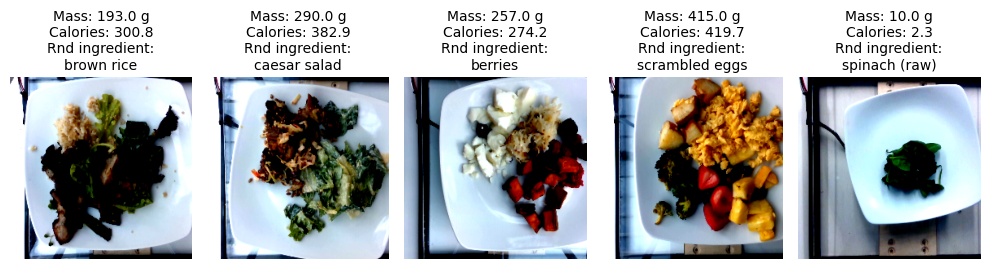

In [5]:
config = Config()

img_dataset_path = 'data/images'
dish_dataset_path = 'data/didh.csv'
ingr_dataset_path = 'data/ingredients.csv'

# Инициализация датасетов
df_dish = pd.read_csv("data/dish.csv")
df_train = df_dish[df_dish["split"] == "train"]
df_test  = df_dish[df_dish["split"] == "test"]

df_ingr = pd.read_csv("data/ingredients.csv")

train_dataset = FoodDataset(df_dish=df_train,
                       df_ingr=df_ingr,
                       transforms=get_image_transforms(config, 'train'))

val_dataset = FoodDataset(df_dish=df_test,
                       df_ingr=df_ingr,
                       transforms=get_image_transforms(config, 'test'))

plot_images(dataset=val_dataset)

In [6]:
tokenizer = AutoTokenizer.from_pretrained(config.TEXT_MODEL_NAME)

train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    collate_fn=partial(collate_fn, tokenizer=tokenizer))
val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=partial(collate_fn, tokenizer=tokenizer))

In [8]:
train(config=config, 
      train_loader=train_loader, 
      val_loader=val_loader)

Epoch 1/50 | avg_MSE: 111678.70 | Val MSE: 107282.86 | Val MAE: 249.73
Epoch 2/50 | avg_MSE: 112426.49 | Val MSE: 104967.51 | Val MAE: 245.28
Epoch 3/50 | avg_MSE: 106804.96 | Val MSE: 102692.07 | Val MAE: 240.97
Epoch 4/50 | avg_MSE: 104921.16 | Val MSE: 100252.17 | Val MAE: 236.42
Epoch 5/50 | avg_MSE: 102531.07 | Val MSE: 97602.83 | Val MAE: 231.58
Epoch 6/50 | avg_MSE: 99432.83 | Val MSE: 94743.73 | Val MAE: 226.54
Epoch 7/50 | avg_MSE: 96416.49 | Val MSE: 91720.50 | Val MAE: 221.36
Epoch 8/50 | avg_MSE: 93279.60 | Val MSE: 88569.99 | Val MAE: 216.12
Epoch 9/50 | avg_MSE: 91724.41 | Val MSE: 85338.15 | Val MAE: 210.88
Epoch 10/50 | avg_MSE: 86820.58 | Val MSE: 82048.22 | Val MAE: 205.74
Epoch 11/50 | avg_MSE: 83199.34 | Val MSE: 78720.57 | Val MAE: 200.76
Epoch 12/50 | avg_MSE: 80069.10 | Val MSE: 75468.34 | Val MAE: 196.22
Epoch 13/50 | avg_MSE: 77179.97 | Val MSE: 72258.73 | Val MAE: 191.83
Epoch 14/50 | avg_MSE: 73786.53 | Val MSE: 69113.47 | Val MAE: 187.52
Epoch 15/50 | avg_MS

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.776427].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.6544226].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.8112854].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.8199999].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5418272..1.776427].


EVAL MAE: 96.99


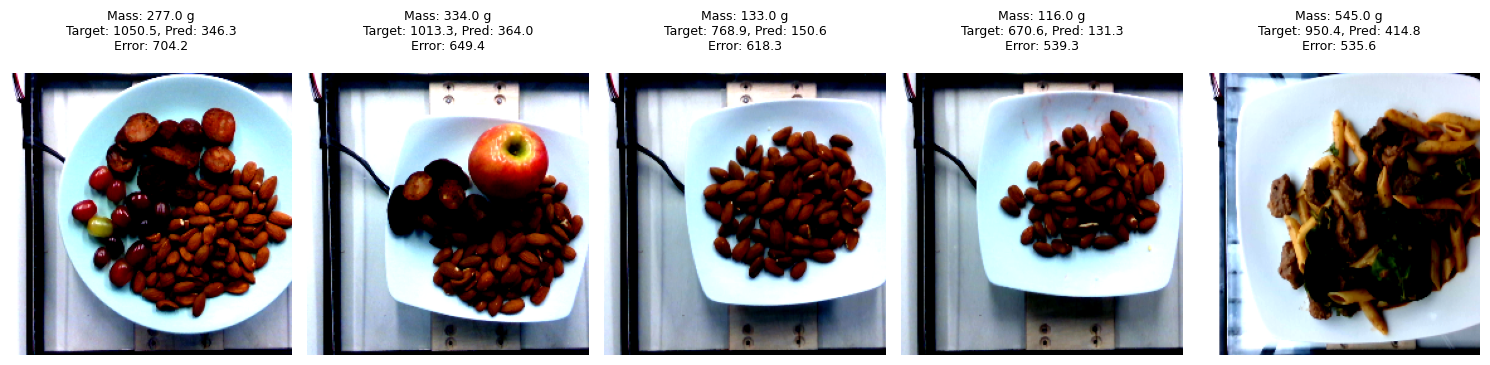

In [15]:
evaluate_model(MultimodalModel, 
               config.SAVE_PATH, 
               val_loader,
               config)

Итоговая MAE вышла 96.99

По фотографиям можно увидеть, что наибольшая ошибка у сложных, миксованных блюд. Также можно обратить внимание, что большинство блюд с высокой ошибкой содержит миндаль

Для улучшения модели можно попробовать:
- Использовать более сложные модели, например, заменив `bert-base-uncased`
- Добавить список ингредиентов не только текстов в collate_fn